In [15]:
import sys
from decouple import config
MAIN_PATH = config('MAIN_PATH')
sys.path.insert(1, MAIN_PATH)
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
import matplotlib.dates as mdates
import matplotlib.lines as mlines

from utils.sim_data import convert_mins_to_string, convert_string_to_mins


TITLE_FONT_SIZE = 20
MEAL_FONT_SIZE = 20
AXIS_FONT_SIZE = 16
LEGEND_FONT_SIZE = 16
EPISODE_HEADERS = ["epi", "cgm", "cgm_pred", "ins", "meal", "day_hour", "day_min", 't']

def import_pred_csv(file_loc):
    df = pd.read_csv(file_loc, header='infer')
    return df

def graph_episode_data(df, t_epi=0):

    # data frame set up
    df = df.rename(columns={"epi" : "episode", "carbs" : "meal"})
    if not t_epi in df["episode"]: raise IndexError(f"Episode {t_epi} does not exist.")
    df = df[df['episode'].astype(int) == t_epi].reset_index()

    print(df)

    base_t = datetime(2020, 1, 1, 0, 0)

    df["t"] = df["t"].apply(lambda t : convert_mins_to_string(int(t)*5))
    df["time"] = df["t"].apply(lambda t : base_t + timedelta(minutes=convert_string_to_mins(t)))
    df["day_hour"] = df["t"].apply(lambda t : int(t.split(':')[1]))
    df["day_min"] = df["t"].apply(lambda t : int(t.split(':')[2]))

    for col_name in ["rew","rl_ins","mu","sigma","prob","state_val"]: df[col_name] = 0.0

    # plotting
    fig = plt.figure(figsize=(12, 6))
    ax2 = fig.add_subplot(111)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    ax2.set_yscale('log')
    ax2.set_ylim((1e-3, 5))
    divider = make_axes_locatable(ax2)
    ax = divider.append_axes("top", size=3.0, pad=0.02, sharex=ax2)
    #ax.set_ylim((5, 600))

    cgm_color = '#1F77B4'
    cgm_pred_color = '#FF0080'
    ins_color = 'mediumseagreen'
    meal_color = '#800000'

    max_ins = max(df['ins'])
    max_cgm = min(max(df['cgm']) + 100, 620)

    ax.plot(df['time'], df['cgm'], markerfacecolor=cgm_color, color=cgm_color, linewidth=2.0)
    ax.plot(df['time'], df['cgm_pred'], markerfacecolor=cgm_pred_color, color=cgm_pred_color, linewidth=2.0)

    ax2.bar(df['time'], df['ins'], (1/288), color=ins_color)  # width of bar is given in days

    ax.axhline(y=54, color='r', linestyle='--')
    ax.axhspan(70, 180, alpha=0.2, color='limegreen', lw=0)

    x = True
    for t in range(0, len(df)):
        if df.iloc[t]['meal']:
            off_set = (max_cgm - 125) if x else (max_cgm - 75)
            ax.annotate('Carbohydrates: ' + str(df.iloc[t]['meal'])+'g', (df.iloc[t]['time'], off_set), color=meal_color, fontsize=MEAL_FONT_SIZE)  #df.iloc[t]['cgm']
            ax.plot((df.iloc[t]['time'], df.iloc[t]['time']), (df.iloc[t]['cgm'], off_set), color=meal_color)

            m_a_min, sample_rate = 20, 5
            m_a_offset = int(m_a_min / sample_rate)
            x = not(x)

    start_time = df['time'].iloc[0]  # end_time = df['time'].iloc[-1]
    ax2.set_xlim([start_time, start_time + timedelta(hours=4)]) # start_time + timedelta(hours=3)]
    ax2.xaxis.set_minor_locator(mdates.AutoDateLocator())
    ax2.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M\n'))
    ax2.xaxis.set_major_locator(mdates.DayLocator())
    # ax2.xaxis.set_major_formatter(mdates.DateFormatter('\n%b %d'))
    ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda *args, **kwargs: ''))

    ax2.tick_params(axis='x', which='major', labelsize=AXIS_FONT_SIZE)  # for major ticks
    ax2.tick_params(axis='x', which='minor', labelsize=AXIS_FONT_SIZE)   # for minor ticks

    ax.tick_params(axis='x', which='major', labelsize=20, colors="#FFFFFF")  # for major ticks
    ax.tick_params(axis='x', which='minor', labelsize=20, colors="#FFFFFF")   # for minor ticks

    ax.tick_params(axis='y', which='major', labelsize=AXIS_FONT_SIZE)  # for major ticks
    ax.tick_params(axis='y', which='minor', labelsize=AXIS_FONT_SIZE)   # for minor ticks

    ax2.tick_params(axis='y', which='major', labelsize=AXIS_FONT_SIZE)  # for major ticks
    ax2.tick_params(axis='y', which='minor', labelsize=AXIS_FONT_SIZE)   # for minor ticks

    ax.set_ylim(5, max_cgm)
    var_ins_max = max_ins * (max_cgm / 50)
    #var_ins_max = 1
    #ax2.set_ylim(0, var_ins_max)
    #ax2.set_yscale('log')
    #ax2.set_ylim(1e-4, 10000)
    #ax2.set_yticks(np.arange(0, var_ins_max + 1, 0.5))

    ax.set_ylabel('    CGM [mg/dL]', color=cgm_color, fontsize=TITLE_FONT_SIZE)
    ax2.set_ylabel('Insulin [U/min]', color=ins_color, fontsize=TITLE_FONT_SIZE)
    ax2.set_xlabel('Time (hrs)', fontsize=TITLE_FONT_SIZE)
    #ax.set_title('Simulation: Glucose Regulation')
    ax.grid()

    cgm_line = mlines.Line2D([], [], color=cgm_color, label='Actual')
    #ins_line = mlines.Line2D([], [], color=ins_color, label='Insulin (Pump: Insulet)')
    cgm_pred_line = mlines.Line2D([], [], color=cgm_pred_color, label='Predicted')
    meal_ann_line = mlines.Line2D([], [], color='k', marker='D', linestyle='None', label='Meal Announcement (20min)')
    ax.legend(handles=[cgm_line, cgm_pred_line], loc='upper right', fontsize=LEGEND_FONT_SIZE)  # meal_ann_line

    ax.axhline(y=250, color='r', linestyle='--')

    # ax.text(df.iloc[1]['time'], 260, 'Severe Hyperglycemia', size=12, color='r')
    # ax.text(df.iloc[1]['time'], 230, 'Hyperglycemia', size=12)
    # ax.text(df.iloc[1]['time'], 100, 'Normoglcemia', size=12, color=cgm_color)
    # ax.text(df.iloc[1]['time'], 54, 'Hypoglycemia', size=12)
    # ax.text(df.iloc[1]['time'], 30, 'Severe Hypoglycemia', size=12, color='r')

    #fig.savefig(experiment.experiment_dir +'/'+ str(tester))

    plt.show()

       epi         cgm    cgm_pred       ins  meal  day_hour  day_min   t
0        0  103.279366  110.267951  0.012245   0.0        18        0   0
1        0  101.895744  114.710150  0.012245   0.0        18        0   1
2        0  101.213805  118.390225  0.012245   0.0        18        0   2
3        0  100.383216  121.879586  0.012245   0.0        18        0   3
4        0   98.974482  124.980862  0.012245   0.0        18        0   4
...    ...         ...         ...       ...   ...       ...      ...  ..
24571  511  105.726508   73.511188  0.006345   0.0         6        0  43
24572  511  102.734257   75.048074  0.017264   0.0         6        0  44
24573  511  101.006705   75.099218  0.027767   0.0         7        0  45
24574  511  101.022421   74.028995  0.008807   0.0         7        0  46
24575  511  102.809108   75.475181  0.006496   0.0         7        0  47

[24576 rows x 8 columns]
    index  episode         cgm    cgm_pred       ins  meal  day_hour  day_min  \
0    

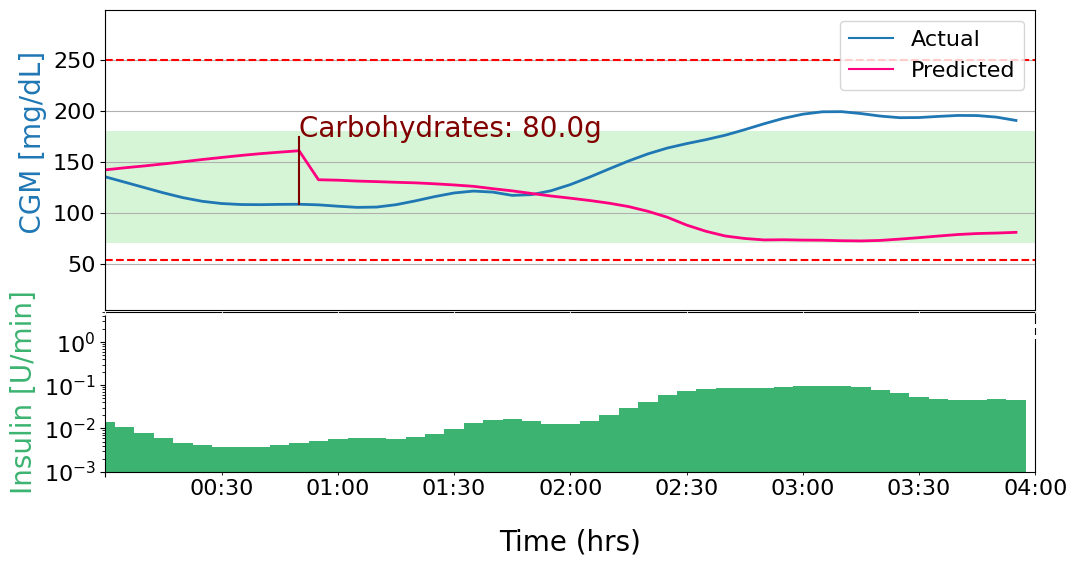

       epi         cgm    cgm_pred       ins  meal  day_hour  day_min   t
0        0  103.279366  110.267951  0.012245   0.0        18        0   0
1        0  101.895744  114.710150  0.012245   0.0        18        0   1
2        0  101.213805  118.390225  0.012245   0.0        18        0   2
3        0  100.383216  121.879586  0.012245   0.0        18        0   3
4        0   98.974482  124.980862  0.012245   0.0        18        0   4
...    ...         ...         ...       ...   ...       ...      ...  ..
24571  511  105.726508   73.511188  0.006345   0.0         6        0  43
24572  511  102.734257   75.048074  0.017264   0.0         6        0  44
24573  511  101.006705   75.099218  0.027767   0.0         7        0  45
24574  511  101.022421   74.028995  0.008807   0.0         7        0  46
24575  511  102.809108   75.475181  0.006496   0.0         7        0  47

[24576 rows x 8 columns]
    index  episode         cgm    cgm_pred       ins  meal  day_hour  day_min  \
0    

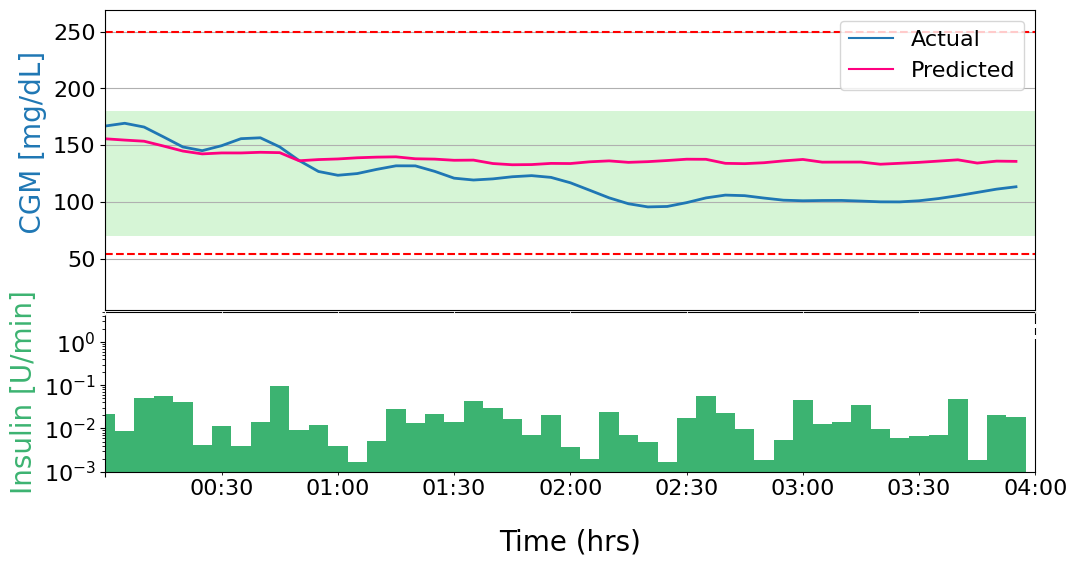

       epi         cgm    cgm_pred       ins  meal  day_hour  day_min   t
0        0  103.279366  110.267951  0.012245   0.0        18        0   0
1        0  101.895744  114.710150  0.012245   0.0        18        0   1
2        0  101.213805  118.390225  0.012245   0.0        18        0   2
3        0  100.383216  121.879586  0.012245   0.0        18        0   3
4        0   98.974482  124.980862  0.012245   0.0        18        0   4
...    ...         ...         ...       ...   ...       ...      ...  ..
24571  511  105.726508   73.511188  0.006345   0.0         6        0  43
24572  511  102.734257   75.048074  0.017264   0.0         6        0  44
24573  511  101.006705   75.099218  0.027767   0.0         7        0  45
24574  511  101.022421   74.028995  0.008807   0.0         7        0  46
24575  511  102.809108   75.475181  0.006496   0.0         7        0  47

[24576 rows x 8 columns]
    index  episode         cgm    cgm_pred       ins  meal  day_hour  day_min  \
0    

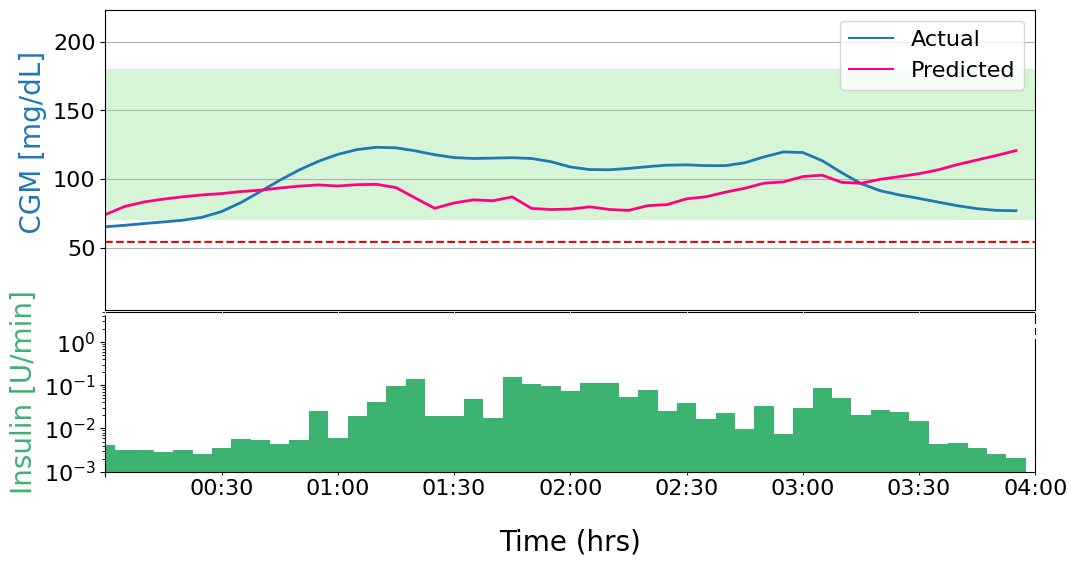

       epi         cgm    cgm_pred       ins  meal  day_hour  day_min   t
0        0  103.279366  110.267951  0.012245   0.0        18        0   0
1        0  101.895744  114.710150  0.012245   0.0        18        0   1
2        0  101.213805  118.390225  0.012245   0.0        18        0   2
3        0  100.383216  121.879586  0.012245   0.0        18        0   3
4        0   98.974482  124.980862  0.012245   0.0        18        0   4
...    ...         ...         ...       ...   ...       ...      ...  ..
24571  511  105.726508   73.511188  0.006345   0.0         6        0  43
24572  511  102.734257   75.048074  0.017264   0.0         6        0  44
24573  511  101.006705   75.099218  0.027767   0.0         7        0  45
24574  511  101.022421   74.028995  0.008807   0.0         7        0  46
24575  511  102.809108   75.475181  0.006496   0.0         7        0  47

[24576 rows x 8 columns]
    index  episode         cgm   cgm_pred       ins  meal  day_hour  day_min  \
0     

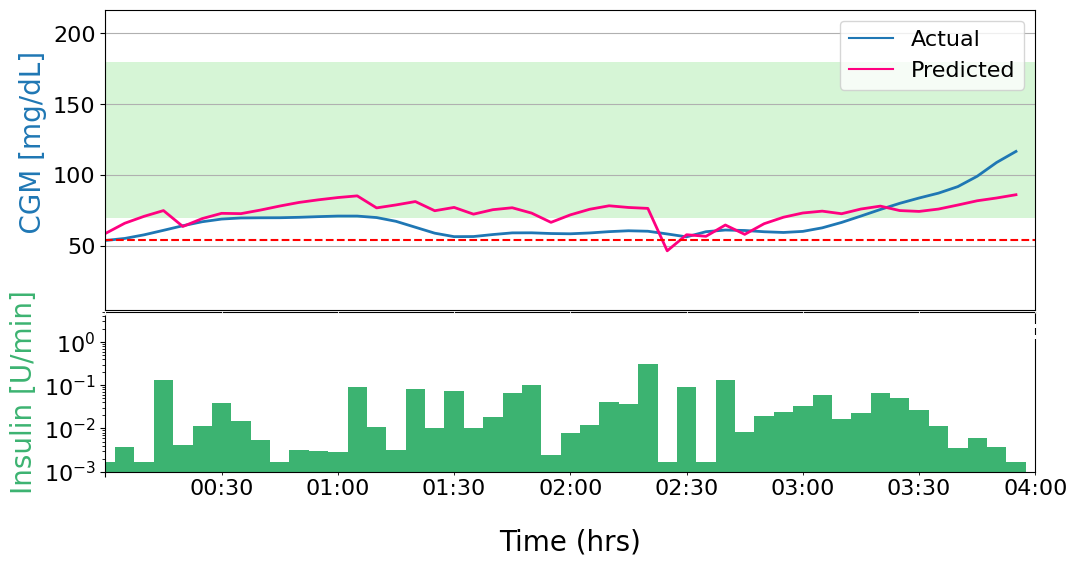

       epi         cgm    cgm_pred       ins  meal  day_hour  day_min   t
0        0  103.279366  110.267951  0.012245   0.0        18        0   0
1        0  101.895744  114.710150  0.012245   0.0        18        0   1
2        0  101.213805  118.390225  0.012245   0.0        18        0   2
3        0  100.383216  121.879586  0.012245   0.0        18        0   3
4        0   98.974482  124.980862  0.012245   0.0        18        0   4
...    ...         ...         ...       ...   ...       ...      ...  ..
24571  511  105.726508   73.511188  0.006345   0.0         6        0  43
24572  511  102.734257   75.048074  0.017264   0.0         6        0  44
24573  511  101.006705   75.099218  0.027767   0.0         7        0  45
24574  511  101.022421   74.028995  0.008807   0.0         7        0  46
24575  511  102.809108   75.475181  0.006496   0.0         7        0  47

[24576 rows x 8 columns]
    index  episode         cgm    cgm_pred       ins  meal  day_hour  day_min  \
0    

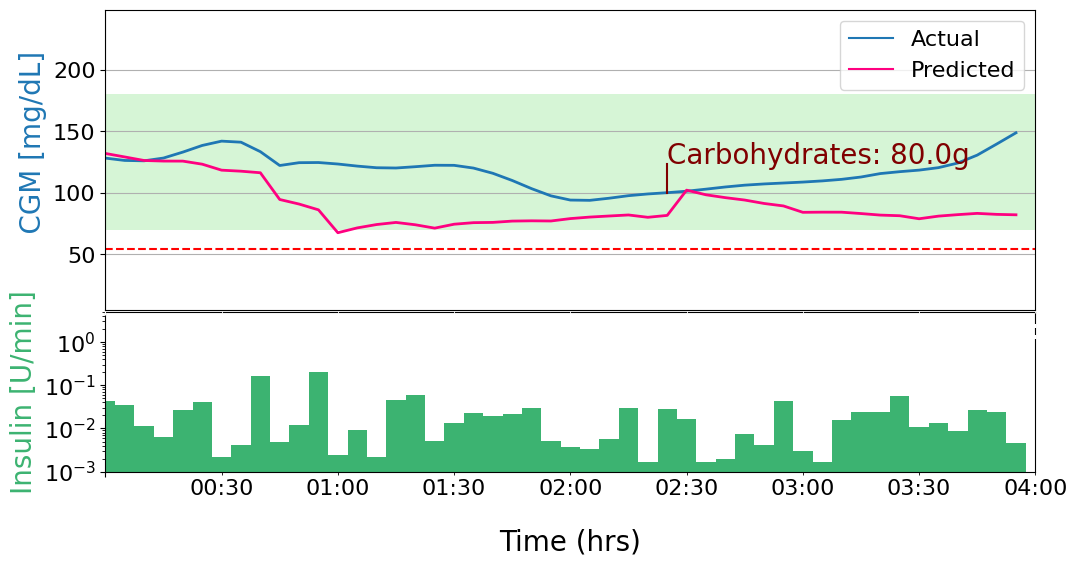

In [16]:
saves_folder = MAIN_PATH + "/experiments/glucose_prediction/saves/"
save_name = "test_21"
vld_index = 12
# epi = 8

for epi in [1, 200, 8,12,16]:
    csv_dest = saves_folder + save_name + "/vld_saves/vld_trials_" + str(vld_index) + ".txt"

    trial_df = import_pred_csv(csv_dest)
    print(trial_df)

    graph_episode_data(trial_df, epi)